In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay
)

import matplotlib.pyplot as plt

In [6]:
import pandas as pd
from pathlib import Path

data_dir = Path("data")

# Parse date_utc as datetime
df = pd.read_csv(
    data_dir / "spacex_era5_ksc_launches_2010_2024.csv",
    parse_dates=["date_utc"]
)

# --- Rebuild time features ---

# Align to hour
df["date_hour"] = df["date_utc"].dt.floor("h")

df["launch_hour"] = df["date_hour"].dt.hour
df["launch_month"] = df["date_hour"].dt.month

# Optional: season feature (DJF/MAM/JJA/SON)
def month_to_season(m):
    if m in [12, 1, 2]:
        return "DJF"
    elif m in [3, 4, 5]:
        return "MAM"
    elif m in [6, 7, 8]:
        return "JJA"
    else:
        return "SON"

df["season"] = df["launch_month"].apply(month_to_season)

# --- Rebuild scrub_reason and weather_issue_flag (from Notebook 3) ---

def flag_any_scrub_or_failure(details: str) -> bool:
    if not isinstance(details, str):
        return False
    text = details.lower()
    keywords = [
        "scrub", "scrubbed", "abort", "aborted",
        "delayed", "delay", "postpone", "postponed",
        "failure", "failed", "anomaly",
    ]
    return any(kw in text for kw in keywords)

df["text_scrub_like"] = df["details"].apply(flag_any_scrub_or_failure)

def classify_scrub_reason(details: str) -> str:
    if not isinstance(details, str):
        return "unknown"
    text = details.lower()

    weather_keywords = [
        "weather", "upper-level winds", "upper level winds",
        "lightning", "storm", "rain", "thick cloud",
        "cloud rule", "anvil", "cumulus", "unfavorable conditions",
    ]

    technical_keywords = [
        "engine", "merlin", "valve", "sensor", "pressur",
        "computer", "autosequence", "guidance", "leak",
        "fuel", "oxidizer", "fairing", "hardware", "propellant",
    ]

    range_keywords = [
        "range violation", "range held", "boat in", "ship in",
        "keep-out zone", "airspace", "danger zone",
    ]

    if any(kw in text for kw in weather_keywords):
        return "weather"
    if any(kw in text for kw in technical_keywords):
        return "technical"
    if any(kw in text for kw in range_keywords):
        return "range"
    return "unknown"

df["scrub_reason"] = df["details"].apply(classify_scrub_reason)
df["weather_issue_flag"] = (df["scrub_reason"] == "weather").astype(int)

print("Columns now include:", [c for c in df.columns if c.startswith("launch_")] + ["season"])
print("weather_issue_flag counts:\n", df["weather_issue_flag"].value_counts())



Columns now include: ['launch_hour', 'launch_month', 'season']
weather_issue_flag counts:
 weather_issue_flag
0    150
1      4
Name: count, dtype: int64


In [7]:
target_col = "weather_issue_flag"

numeric_features = [
    "wind_speed_10m",
    "t2m_C",
    "tcc_frac",
    "tp_mmhr",
    "cp_mmhr",
    "msl",
    "launch_hour",
    "launch_month",
]

categorical_features = []
if "rocket_name" in df.columns:
    categorical_features.append("rocket_name")
if "season" in df.columns:
    categorical_features.append("season")

all_feature_cols = numeric_features + categorical_features

# Drop rows missing target or any key feature
df_model = df.dropna(subset=[target_col] + numeric_features).copy()

X = df_model[all_feature_cols]
y = df_model[target_col].astype(int)

print("X shape:", X.shape)
print("Target distribution:\n", y.value_counts())


X shape: (154, 10)
Target distribution:
 weather_issue_flag
0    150
1      4
Name: count, dtype: int64


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y  # preserve class ratio
)

In [9]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)


In [10]:
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    )),
])

rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced",
        min_samples_leaf=2
    )),
])


In [11]:
log_reg_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


=== Logistic Regression ===
ROC AUC: 0.39473684210526316

              precision    recall  f1-score   support

           0      0.970     0.842     0.901        38
           1      0.000     0.000     0.000         1

    accuracy                          0.821        39
   macro avg      0.485     0.421     0.451        39
weighted avg      0.945     0.821     0.878        39



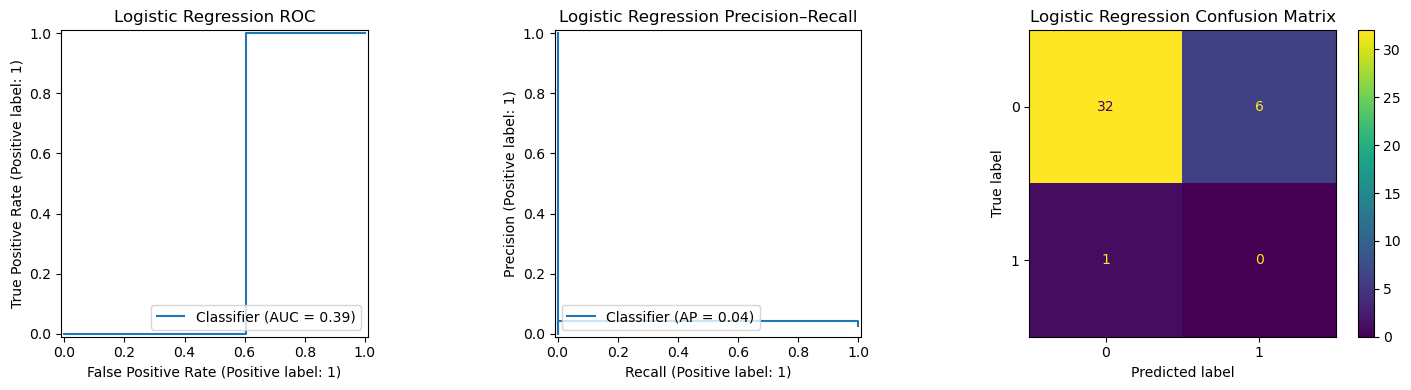

=== Random Forest ===
ROC AUC: 0.368421052631579

              precision    recall  f1-score   support

           0      0.974     1.000     0.987        38
           1      0.000     0.000     0.000         1

    accuracy                          0.974        39
   macro avg      0.487     0.500     0.494        39
weighted avg      0.949     0.974     0.962        39



c:\Users\bolhu\miniforge3\envs\xarray-climate\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bolhu\miniforge3\envs\xarray-climate\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\bolhu\miniforge3\envs\xarray-climate\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

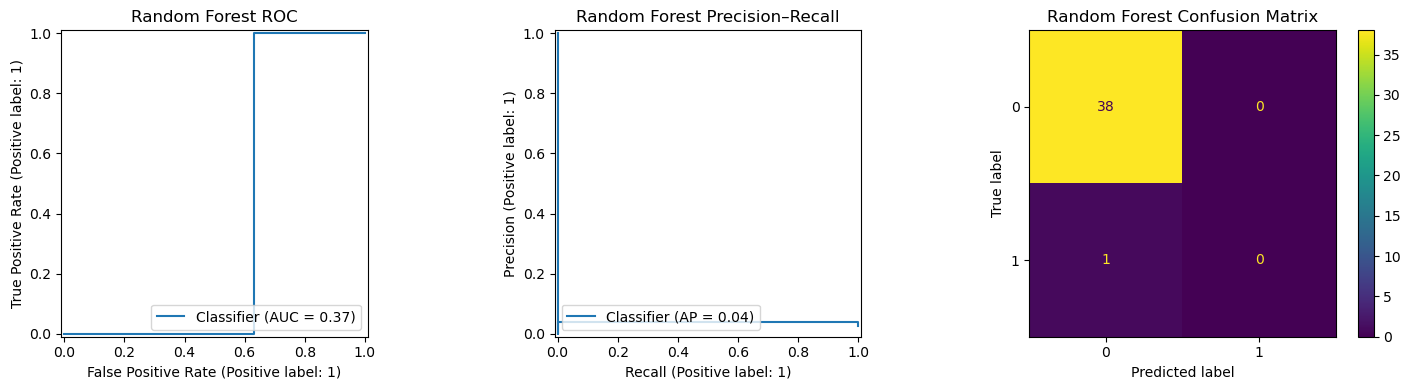

In [12]:
def evaluate_model(model, name):
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    print(f"=== {name} ===")
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print()
    print(classification_report(y_test, y_pred, digits=3))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    RocCurveDisplay.from_predictions(y_test, y_prob, ax=axes[0])
    axes[0].set_title(f"{name} ROC")

    PrecisionRecallDisplay.from_predictions(y_test, y_prob, ax=axes[1])
    axes[1].set_title(f"{name} Precision–Recall")

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[2])
    axes[2].set_title(f"{name} Confusion Matrix")

    plt.tight_layout()
    plt.show()

evaluate_model(log_reg_clf, "Logistic Regression")
evaluate_model(rf_clf, "Random Forest")


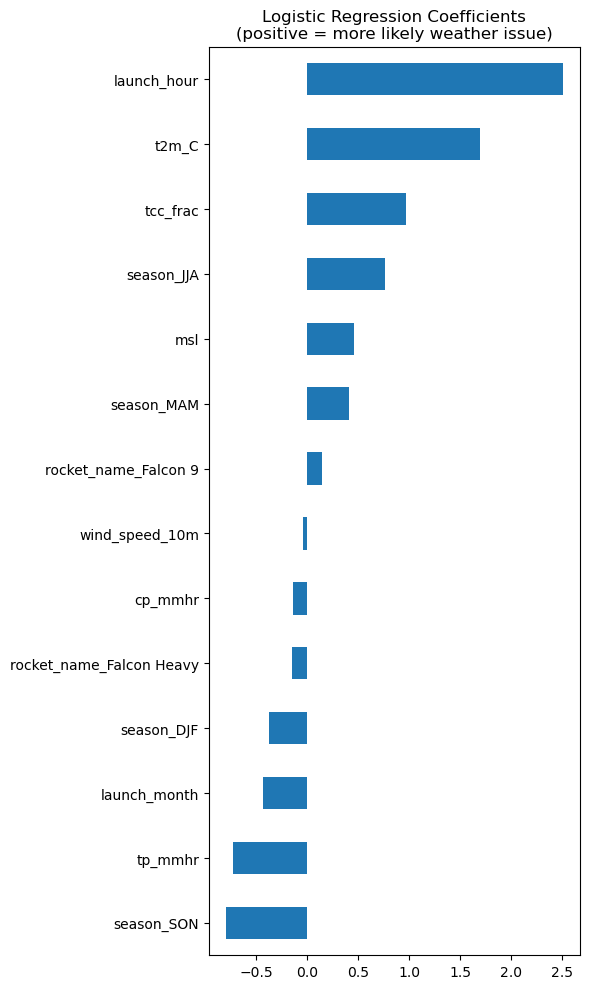

launch_hour                 2.507643
t2m_C                       1.688509
tcc_frac                    0.966300
season_JJA                  0.764248
msl                         0.461022
season_MAM                  0.411284
rocket_name_Falcon 9        0.148846
wind_speed_10m             -0.045200
cp_mmhr                    -0.138589
rocket_name_Falcon Heavy   -0.150317
dtype: float64

In [13]:
log_reg = log_reg_clf.named_steps["clf"]

# One-hot feature names
cat_names = []
if categorical_features:
    ohe = log_reg_clf.named_steps["preprocess"].named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(categorical_features))

feature_names = numeric_features + cat_names

coef_series = pd.Series(log_reg.coef_[0], index=feature_names)
coef_series.sort_values().plot(kind="barh", figsize=(6, 10))
plt.title("Logistic Regression Coefficients\n(positive = more likely weather issue)")
plt.tight_layout()
plt.show()

coef_series.sort_values(ascending=False).head(10)


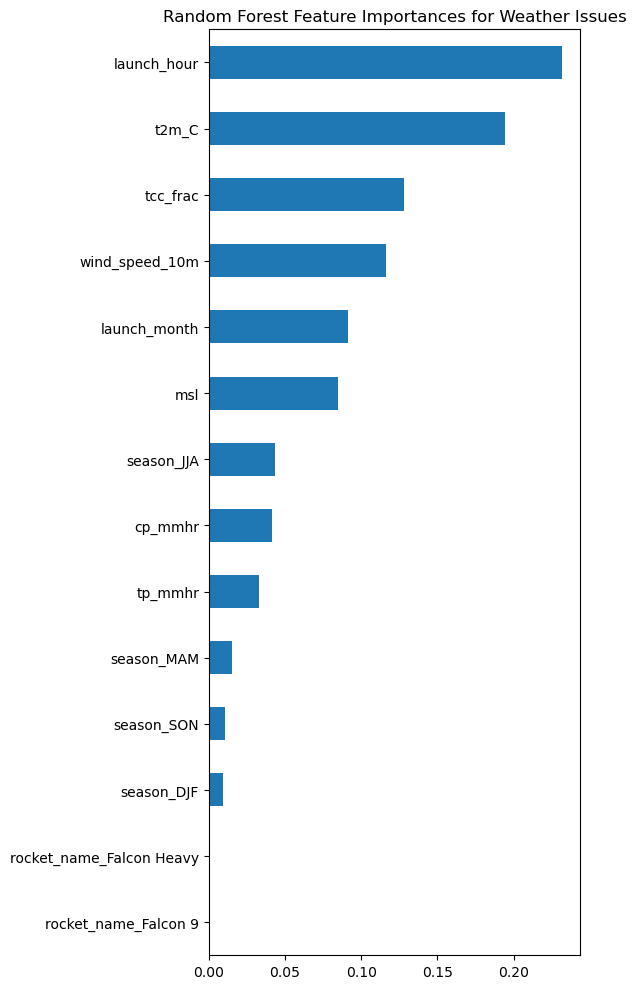

launch_hour       0.231899
t2m_C             0.194200
tcc_frac          0.127818
wind_speed_10m    0.116383
launch_month      0.091566
msl               0.084560
season_JJA        0.043560
cp_mmhr           0.041333
tp_mmhr           0.033219
season_MAM        0.015027
dtype: float64

In [14]:
rf = rf_clf.named_steps["clf"]

rf_importances = pd.Series(
    rf.feature_importances_,
    index=feature_names
)

rf_importances.sort_values().plot(kind="barh", figsize=(6, 10))
plt.title("Random Forest Feature Importances for Weather Issues")
plt.tight_layout()
plt.show()

rf_importances.sort_values(ascending=False).head(10)


In [15]:
def predict_weather_issue_probability(model, conditions: dict) -> float:
    """
    conditions: dict of feature_name -> value for one hypothetical launch.
    Required keys: numeric_features + relevant categorical (e.g., rocket_name, season).
    """
    # Build row with defaults
    row = {col: np.nan for col in all_feature_cols}
    row.update(conditions)
    X_new = pd.DataFrame([row])
    prob = model.predict_proba(X_new)[0, 1]
    return prob


In [16]:
nice_weather = {
    "wind_speed_10m": 6.0,
    "t2m_C": 24.0,
    "tcc_frac": 0.2,
    "tp_mmhr": 0.0,
    "cp_mmhr": 0.0,
    "msl": 101300,
    "launch_hour": 20,
    "launch_month": 3,
}
if "rocket_name" in categorical_features:
    nice_weather["rocket_name"] = "Falcon 9"
if "season" in categorical_features:
    nice_weather["season"] = "MAM"

bad_weather = {
    "wind_speed_10m": 18.0,
    "t2m_C": 25.0,
    "tcc_frac": 0.95,
    "tp_mmhr": 5.0,
    "cp_mmhr": 3.0,
    "msl": 100500,
    "launch_hour": 20,
    "launch_month": 7,
}
if "rocket_name" in categorical_features:
    bad_weather["rocket_name"] = "Falcon 9"
if "season" in categorical_features:
    bad_weather["season"] = "JJA"

print("P(weather issue) nice:", predict_weather_issue_probability(rf_clf, nice_weather))
print("P(weather issue) bad :", predict_weather_issue_probability(rf_clf, bad_weather))


P(weather issue) nice: 0.018423103440689766
P(weather issue) bad : 0.07365297394147226
